In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

##Import any other packages you may need here
from itertools import chain

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [82]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
display(all_xray_df.sample(3, random_state=0))

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
display(sample_df.sample(3, random_state=0))

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
10539  00002723_010.png     No Finding           10        2723           58   
39718  00010377_002.png     No Finding            2       10377           66   
29391  00007651_000.png   Cardiomegaly            0        7651           71   

      Patient Gender View Position  OriginalImage[Width  Height]  \
10539              F            PA                 2992     2991   
39718              M            AP                 2500     2048   
29391              M            PA                 2048     2500   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  
10539                        0.143  0.143          NaN  
39718                        0.168  0.168          NaN  
29391                        0.168  0.168          NaN

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
731   00003838_000.png     No Finding            0        3838        052Y   
1569  00008127_001.png     No Finding            1        8127        032Y   
5081  00027001_001.png     No Finding            1       27001        057Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
731               F            PA                2048                 2500   
1569              F            PA                2048                 2500   
5081              F            AP                3056                 2544   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
731                         0.168                        0.168  
1569                        0.168                        0.168  
5081                        0.139                        0.139

In [83]:
all_xray_df[all_xray_df["Finding Labels"].str.contains("Pneumonia")]

Image Index                                     Finding Labels  \
48      00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126     00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253     00000056_000.png                                   Nodule|Pneumonia   
276     00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279     00000061_015.png                                          Pneumonia   
...                  ...                                                ...   
111557  00030536_007.png                Atelectasis|Consolidation|Pneumonia   
111627  00030570_001.png                       Edema|Infiltration|Pneumonia   
111767  00030621_002.png                                          Pneumonia   
111845  00030637_016.png                            Consolidation|Pneumonia   
112115  00030801_001.png                                     Mass|Pneumonia   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
48               10          13           60              M            AP   
126              12          32           55              F            AP   
253               0          56           76              M            PA   
276              12          61           77              M            AP   
279              15          61           77              M            AP   
...             ...         ...          ...            ...           ...   
111557            7       30536           56              F            AP   
111627            1       30570           29              F            AP   
111767            2       30621           22              F            AP   
111845           16       30637           48              M            AP   
112115            1       30801           39              M            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
48                     3056     2544                        0.139  0.139   
126                    2500     2048                        0.168  0.168   
253                    2500     2048                        0.168  0.168   
276                    3056     2544                        0.139  0.139   
279                    3056     2544                        0.139  0.139   
...                     ...      ...                          ...    ...   
111557                 3056     2544                        0.139  0.139   
111627                 3056     2544                        0.139  0.139   
111767                 3056     2544                        0.139  0.139   
111845                 3056     2544                        0.139  0.139   
112115                 2048     2500                        0.168  0.168   

        Unnamed: 11  
48              NaN  
126             NaN  
253             NaN  
276             NaN  
279             NaN  
...             ...  
111557          NaN  
111627          NaN  
111767          NaN  
111845          NaN  
112115          NaN  

[1431 rows x 12 columns]

### Clean data


In [84]:
sample_df[sample_df["Patient Age"].str.contains(r"Y") == False]["Patient Age"]

3865    013M
4749    001D
Name: Patient Age, dtype: object


**"Patient Age" column of sample_df includes the following symbols: `Y, M, D`(almost all have `Y`).
Although they can be guessed as Y: year, M: month, D: day, I simply ommit the cases of `M` and `D` since there is only one case for each symbol.**

In [85]:
if sample_df["Patient Age"].dtype == object:
    sample_df = sample_df[sample_df["Patient Age"].str.contains('Y')]
    sample_df["Patient Age"] = sample_df["Patient Age"].str.replace("Y", "").map(int)

In [86]:
sample_df["Patient Age"].sample(3, random_state=0)

731     52
1569    32
3684    41
Name: Patient Age, dtype: int64

**Check the size of dataset**

In [87]:
print("Check the size of dataframes\n")
print("\t all:", all_xray_df.shape,"\tsample:", sample_df.shape)

print("\n")

print("What is stored in 'Unnamed:11' column?\n")
print("\t", all_xray_df["Unnamed: 11"].value_counts())

Check the size of dataframes

	 all: (112120, 12) 	sample: (5604, 11)


What is stored in 'Unnamed:11' column?

	 Series([], Name: Unnamed: 11, dtype: int64)


**Set same column name through sample and all  dataframe. Remove needless column.**


In [88]:
def normalize_dataframe(df):
    """Remove Unnamed:11 column and rename columns    
    """
    
    column_names = [
        "ImageIndex", "Labels", "FollowUp",
        "PatientID", "PatientAge", "PatientGender",
        "ViewPosition", "OriginalImageWidth", "OriginalImageHeight",
        "OriginalImagePixelSpacing_x", "OriginalImagePixelSpacing_y"]

    if df.shape[1] == 12:    
        # remove "Unnamed:11"  column (it looks meaningless)
        df = df.iloc[:, 0:-1]
        df.columns = column_names
    else:
        df.columns = column_names
        
    return df

all_xray_df = normalize_dataframe(all_xray_df)
sample_df = normalize_dataframe(sample_df)

In [89]:
all_xray_df.sample(3, random_state=0)

ImageIndex        Labels  FollowUp  PatientID  PatientAge  \
10539  00002723_010.png    No Finding        10       2723          58   
39718  00010377_002.png    No Finding         2      10377          66   
29391  00007651_000.png  Cardiomegaly         0       7651          71   

      PatientGender ViewPosition  OriginalImageWidth  OriginalImageHeight  \
10539             F           PA                2992                 2991   
39718             M           AP                2500                 2048   
29391             M           PA                2048                 2500   

       OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
10539                        0.143                        0.143  
39718                        0.168                        0.168  
29391                        0.168                        0.168

**Set image path corresponding to image index.**

In [90]:
%ls /data/

ARXIV_V5_CHESTXRAY.pdf  images_002/  images_007/  images_012/
BBox_List_2017.csv      images_003/  images_008/  LOG_CHESTXRAY.pdf
Data_Entry_2017.csv     images_004/  images_009/  README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf       images_005/  images_010/  test_list.txt
images_001/             images_006/  images_011/  train_val_list.txt


In [91]:
def set_image_path(df):
    if "ImagePath" in df.columns:
        return
    image_pathes = glob("/data/images*/images/*")
    image_path_map = {p.split("/")[-1] : p for p in image_pathes}
    return df.assign(
        ImagePath = lambda df: df.apply(lambda row: image_path_map[row["ImageIndex"]], axis=1)
    )

all_xray_df = set_image_path(all_xray_df)
sample_df = set_image_path(sample_df)


## 1. Patient age distribution

In [92]:
all_xray_df["PatientAge"].value_counts().sort_index()

1       16
2       83
3       84
4      105
5      137
      ... 
155      2
411      1
412      3
413      1
414      1
Name: PatientAge, Length: 107, dtype: int64

#### Findings
Some data have  apparently a wrong `PatientAge`.
I use only the data with PatientAge between 10 and 80.

11    364
12    336
13    433
14    476
15    540
     ... 
76    560
77    453
78    340
79    262
80    238
Name: PatientAge, Length: 70, dtype: int64


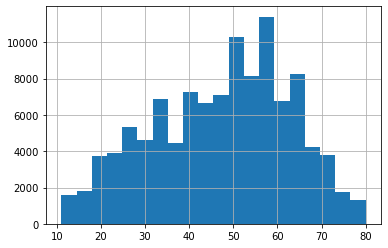

In [93]:
age_filter = "PatientAge > 10 and  PatientAge <= 80"

filtered_df = all_xray_df.query(age_filter)
print(filtered_df["PatientAge"].value_counts().sort_index())

filtered_df["PatientAge"].hist(bins=20)

#### Findings

1. Data has peak around the 50-60 range.


**Add new "AgeRange" column for further analysis.**

In [94]:
def set_age_range(df):
    df.loc[:, "AgeRange"] = pd.cut(df["PatientAge"], bins = [10, 20, 30, 40, 50, 60, 70, 80])
    return df

In [95]:
filtered_df = set_age_range(filtered_df)
sample_df = set_age_range(sample_df)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [96]:
filtered_df[["PatientAge", "AgeRange"]].head()

PatientAge  AgeRange
0          58  (50, 60]
1          58  (50, 60]
2          58  (50, 60]
5          74  (70, 80]
6          75  (70, 80]

## 2. Labels distribution

In [97]:
all_xray_df["Labels"].value_counts()

No Finding                                                 60361
Infiltration                                                9547
Atelectasis                                                 4215
Effusion                                                    3955
Nodule                                                      2705
                                                           ...  
Emphysema|Fibrosis|Infiltration                                1
Hernia|Infiltration|Pneumonia                                  1
Atelectasis|Cardiomegaly|Effusion|Fibrosis|Infiltration        1
Atelectasis|Emphysema|Fibrosis                                 1
Cardiomegaly|Consolidation|Effusion|Infiltration|Nodule        1
Name: Labels, Length: 836, dtype: int64

#### Note

1. When no disease is found, the `No Finding` label is used.
2. When multiple diagnoses are given, each label is separated by the symbol `|`.


In [98]:
def get_all_labels(df):
    all_labels = np.unique(list(chain(*df['Labels'].map(lambda x: x.split('|')).tolist())))
    return [x for x in all_labels if len(x)>0]
    
def expand_label(df, all_labels):
    if "Pneumonia" in df.columns :
        return df
    for c_label in all_labels:
        if len(c_label)>1: # leave out empty labels
            df[c_label] = df['Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
    return df

In [99]:
all_labels = get_all_labels(all_xray_df)
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [100]:
filtered_df = expand_label(filtered_df, all_labels)
sample_df = expand_label(sample_df, all_labels)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [101]:
def plot_label_hist(df, labels, title):
    n = df.shape[0]
    ax = (df[labels].sum() / n).plot.barh(figsize=(10, 8), fontsize=16, grid=True)
    ax.set_xlim(0, 0.65)
    ax.set_title(title, fontsize=16)
    
    for i, v in enumerate((df[labels].sum() / n)):
        ax.text(v+0.01, i - 0.1, f"{v:0.3f}", fontsize=16)

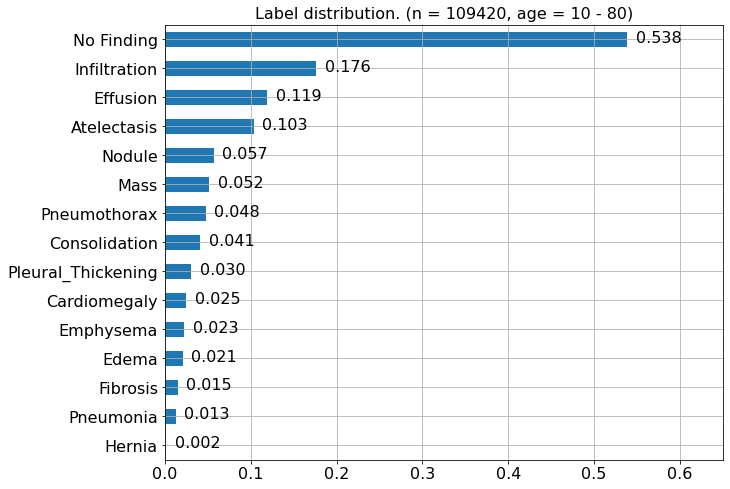

In [102]:
sorted_labels = filtered_df[all_labels].sum().sort_values().index.values

plot_label_hist(filtered_df, sorted_labels, f"Label distribution. (n = {filtered_df.shape[0]}, age = 10 - 80)")

#### Note

1. The 54% of the entries have no disease.
2. Pneumonia accounts for 1% of the toal data.


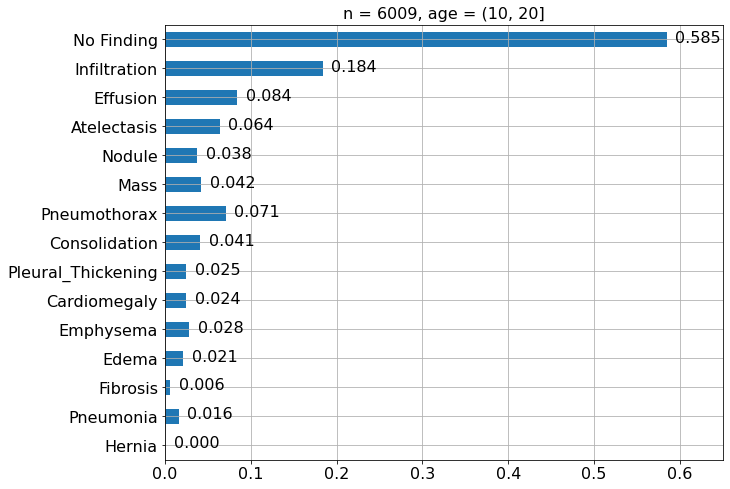

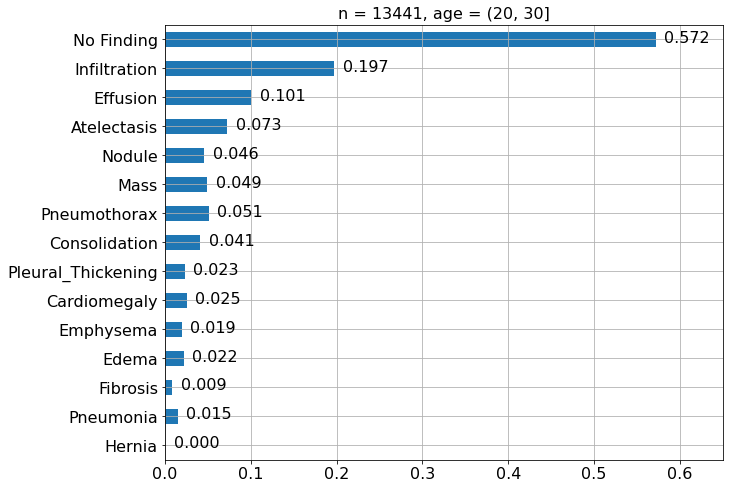

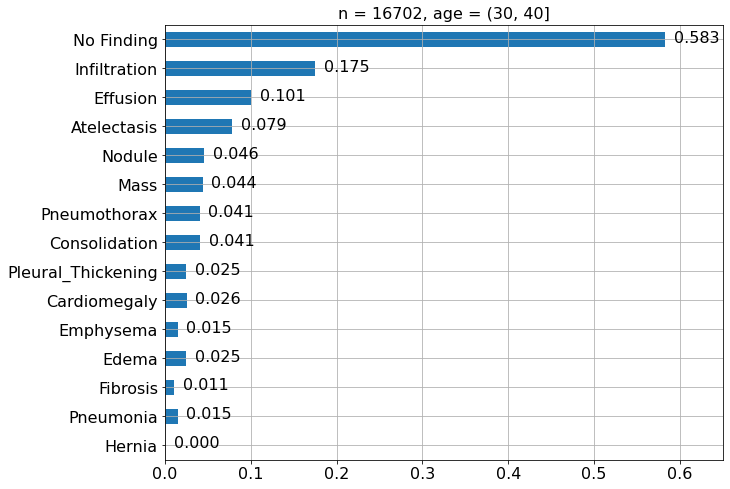

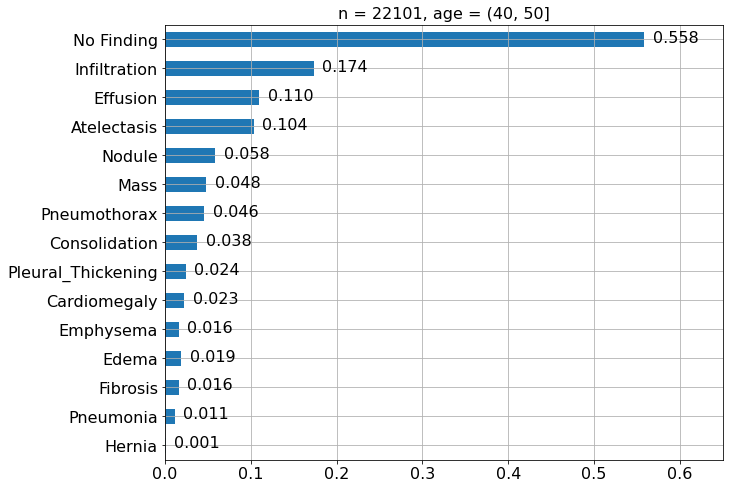

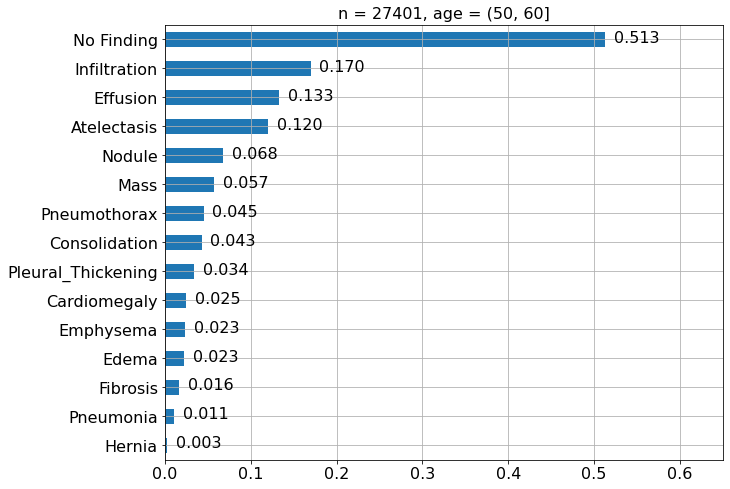

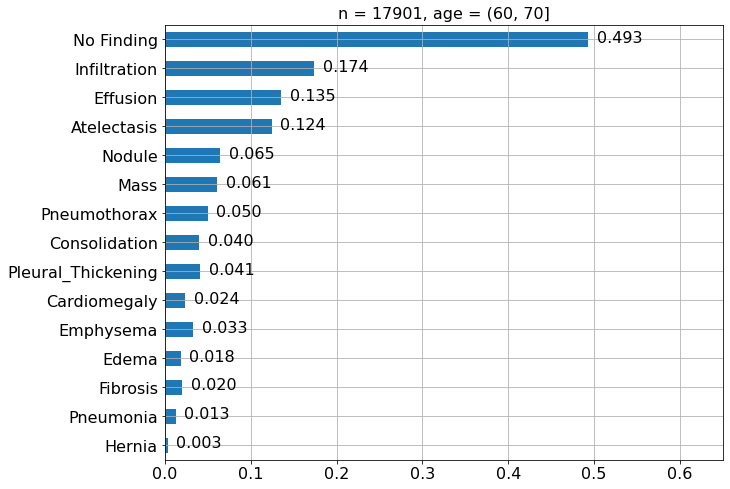

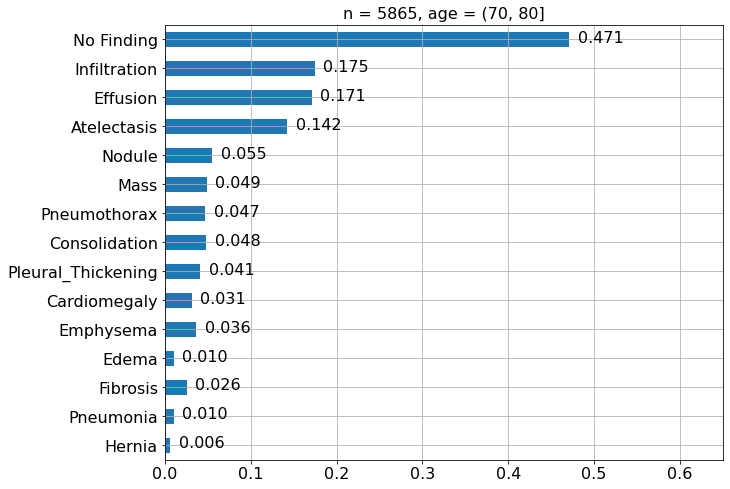

In [103]:
for i, gdf in filtered_df.groupby("AgeRange"):
    plot_label_hist(gdf, sorted_labels, f"n = {gdf.shape[0]}, age = {i}")
    plt.show()

#### Findings
1. The rate of "Pneumonia" looks independent of patients's age except for the range around 10-20


## 3. Patient gender distribution

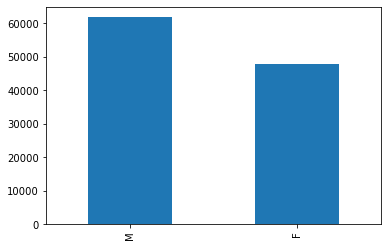

In [104]:
filtered_df["PatientGender"].value_counts().plot.bar()

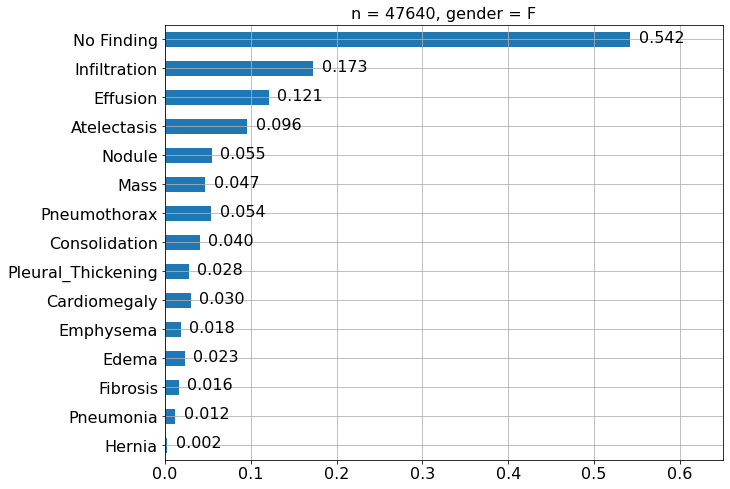

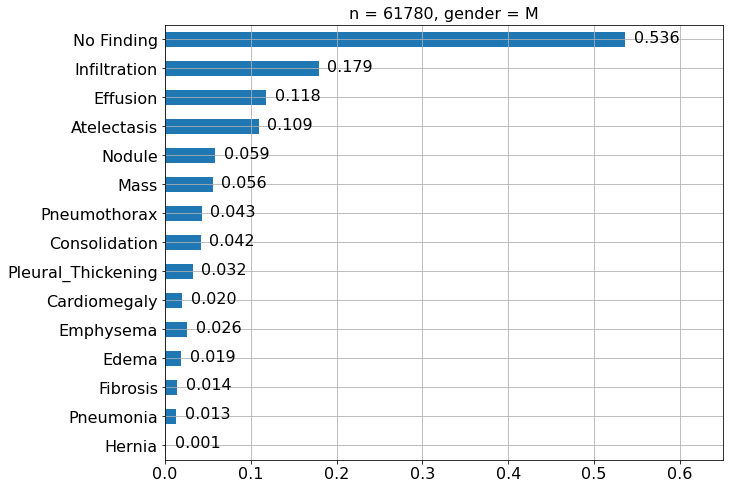

In [105]:
for i, gdf in filtered_df.groupby("PatientGender"):
    plot_label_hist(gdf, sorted_labels, f"n = {gdf.shape[0]}, gender = {i}")
    plt.show()

## 4. View position distribution

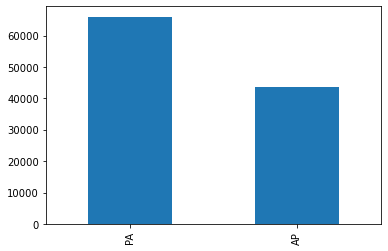

In [106]:
filtered_df["ViewPosition"].value_counts().plot.bar()

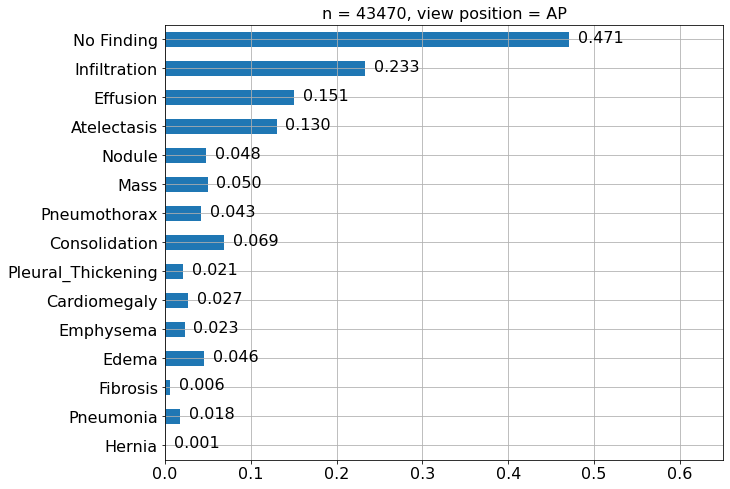

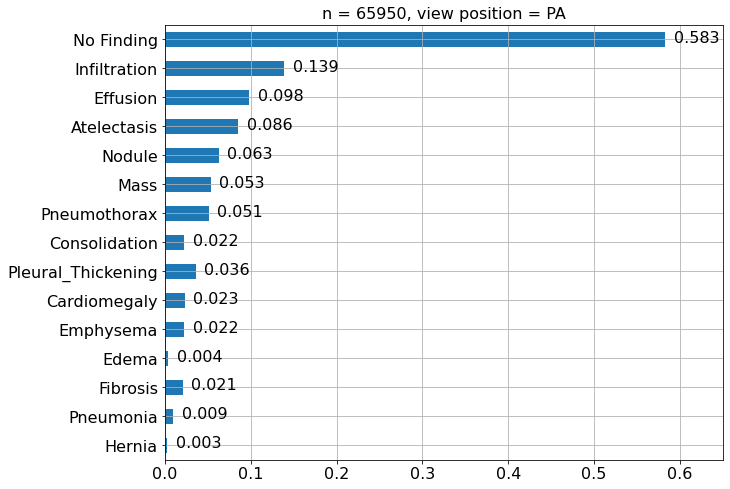

In [107]:
for i, gdf in filtered_df.groupby("ViewPosition"):
    plot_label_hist(gdf, sorted_labels, f"n = {gdf.shape[0]}, view position = {i}")
    plt.show()

#### Findings
1. The view position of the data have significant impact of the distribution of diseas.
2. Comparing to the data "view point = AP", the ratio of "pneumonia" with "view point = AP" has doubled.

## 5. Comorbid distribution

In [108]:
pneumonia_df = filtered_df[filtered_df["Pneumonia"] == 1]

pneumonia_df.head()

ImageIndex                                             Labels  \
48   00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126  00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253  00000056_000.png                                   Nodule|Pneumonia   
276  00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279  00000061_015.png                                          Pneumonia   

     FollowUp  PatientID  PatientAge PatientGender ViewPosition  \
48         10         13          60             M           AP   
126        12         32          55             F           AP   
253         0         56          76             M           PA   
276        12         61          77             M           AP   
279        15         61          77             M           AP   

     OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
48                 3056                 2544                        0.139   
126                2500                 2048                        0.168   
253                2500                 2048                        0.168   
276                3056                 2544                        0.139   
279                3056                 2544                        0.139   

     ...  Emphysema Fibrosis Hernia  Infiltration  Mass  No Finding  Nodule  \
48   ...        0.0      0.0    0.0           0.0   0.0         0.0     0.0   
126  ...        0.0      0.0    0.0           0.0   0.0         0.0     0.0   
253  ...        0.0      0.0    0.0           0.0   0.0         0.0     1.0   
276  ...        0.0      0.0    0.0           1.0   0.0         0.0     0.0   
279  ...        0.0      0.0    0.0           0.0   0.0         0.0     0.0   

     Pleural_Thickening  Pneumonia  Pneumothorax  
48                  0.0        1.0           1.0  
126                 0.0        1.0           0.0  
253                 0.0        1.0           0.0  
276                 1.0        1.0           0.0  
279                 0.0        1.0           0.0  

[5 rows x 28 columns]

In [109]:
comorbid_labels = [l for l in sorted_labels if l not in ["No Finding", "Pneumonia"]]
comorbid_labels

['Hernia',
 'Fibrosis',
 'Edema',
 'Emphysema',
 'Cardiomegaly',
 'Pleural_Thickening',
 'Consolidation',
 'Pneumothorax',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Effusion',
 'Infiltration']

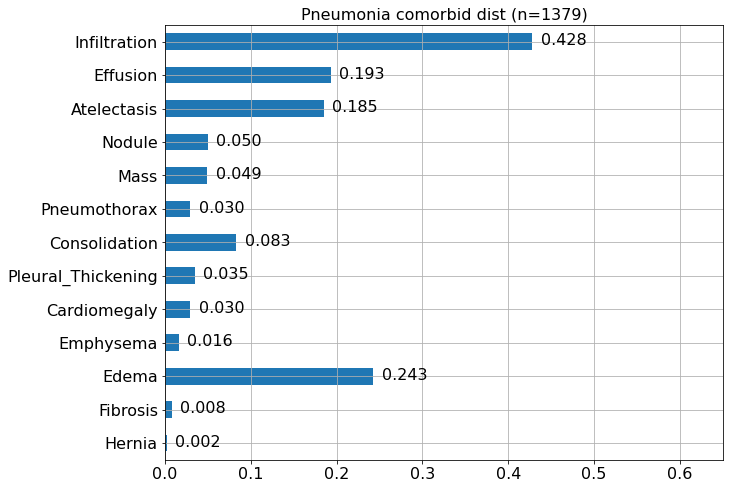

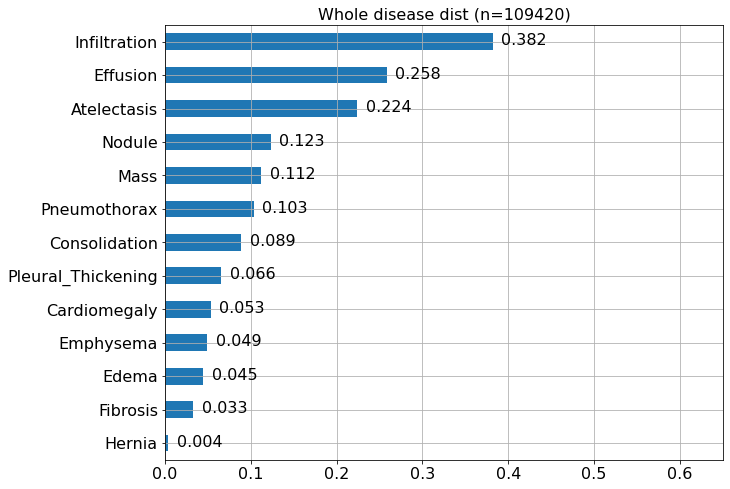

In [110]:
plot_label_hist(pneumonia_df, comorbid_labels, f"Pneumonia comorbid dist (n={pneumonia_df.shape[0]})")
plt.show()
plot_label_hist(filtered_df[filtered_df["No Finding"] == 0], comorbid_labels, f"Whole disease dist (n={filtered_df.shape[0]})")

#### Findings

1. Comparing to whole disease distribution, the ratio of "Edema" is significantly increased.
2. The 42% of "Pneumonia" cases have simultainously "Infiltrate" labels.

## 6. Number of disease per patient

In [111]:
disease_labels =  [l for l in sorted_labels if l not in ["No Finding"]]
disease_labels

['Hernia',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Emphysema',
 'Cardiomegaly',
 'Pleural_Thickening',
 'Consolidation',
 'Pneumothorax',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Effusion',
 'Infiltration']

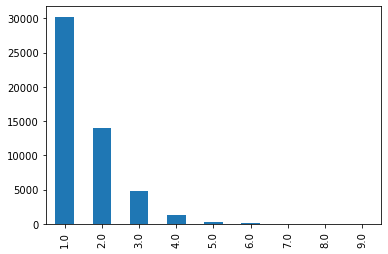

In [112]:
filtered_df[filtered_df["No Finding"] == 0][disease_labels].sum(axis=1).value_counts().sort_index().plot.bar()

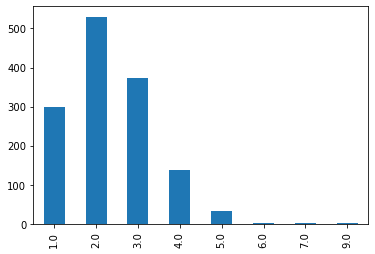

In [113]:
pneumonia_df[pneumonia_df["No Finding"] == 0][disease_labels].sum(axis=1).value_counts().sort_index().plot.bar()


#### Findings

1. In the whole disease, one label per entry is the dominant case.
2. With the patient with pneumonia, the distribution of the number of label per patient  has the peak at the two label. This means that if a patient is labeled as pneumonia, the patient likely have another disease.


## 7. Number of entry per patient

In [114]:
filtered_df["PatientID"].value_counts()[100:200]

14253    57
20673    56
23068    56
9845     56
1373     56
         ..
8009     44
12010    43
18724    43
12863    43
14626    43
Name: PatientID, Length: 100, dtype: int64

In [115]:
display(filtered_df[filtered_df["PatientID"] == 8009][:5])

display(filtered_df[filtered_df["PatientID"] == 8009][-5:])

ImageIndex      Labels  FollowUp  PatientID  PatientAge  \
30690  00008009_000.png  No Finding         0       8009          15   
30691  00008009_001.png  No Finding         1       8009          15   
30692  00008009_002.png  No Finding         2       8009          15   
30693  00008009_003.png  No Finding         3       8009          16   
30694  00008009_004.png  No Finding         4       8009          16   

      PatientGender ViewPosition  OriginalImageWidth  OriginalImageHeight  \
30690             M           PA                2798                 2991   
30691             M           PA                2678                 2841   
30692             M           PA                2690                 2948   
30693             M           AP                2500                 2048   
30694             M           AP                2500                 2048   

       OriginalImagePixelSpacing_x  ...  Emphysema Fibrosis Hernia  \
30690                        0.143  ...        0.0      0.0    0.0   
30691                        0.143  ...        0.0      0.0    0.0   
30692                        0.143  ...        0.0      0.0    0.0   
30693                        0.168  ...        0.0      0.0    0.0   
30694                        0.168  ...        0.0      0.0    0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
30690           0.0   0.0         1.0     0.0                 0.0        0.0   
30691           0.0   0.0         1.0     0.0                 0.0        0.0   
30692           0.0   0.0         1.0     0.0                 0.0        0.0   
30693           0.0   0.0         1.0     0.0                 0.0        0.0   
30694           0.0   0.0         1.0     0.0                 0.0        0.0   

       Pneumothorax  
30690           0.0  
30691           0.0  
30692           0.0  
30693           0.0  
30694           0.0  

[5 rows x 28 columns]

ImageIndex                                   Labels  FollowUp  \
30729  00008009_039.png                             Infiltration        39   
30730  00008009_040.png                               No Finding        40   
30731  00008009_041.png                               No Finding        41   
30732  00008009_042.png               Consolidation|Infiltration        42   
30733  00008009_043.png  Consolidation|Infiltration|Pneumothorax        43   

       PatientID  PatientAge PatientGender ViewPosition  OriginalImageWidth  \
30729       8009          19             M           AP                2500   
30730       8009          19             M           AP                2500   
30731       8009          19             M           AP                2500   
30732       8009          19             M           AP                2500   
30733       8009          19             M           AP                2500   

       OriginalImageHeight  OriginalImagePixelSpacing_x  ...  Emphysema  \
30729                 2048                        0.168  ...        0.0   
30730                 2048                        0.168  ...        0.0   
30731                 2048                        0.168  ...        0.0   
30732                 2048                        0.168  ...        0.0   
30733                 2048                        0.168  ...        0.0   

      Fibrosis Hernia  Infiltration  Mass  No Finding  Nodule  \
30729      0.0    0.0           1.0   0.0         0.0     0.0   
30730      0.0    0.0           0.0   0.0         1.0     0.0   
30731      0.0    0.0           0.0   0.0         1.0     0.0   
30732      0.0    0.0           1.0   0.0         0.0     0.0   
30733      0.0    0.0           1.0   0.0         0.0     0.0   

       Pleural_Thickening  Pneumonia  Pneumothorax  
30729                 0.0        0.0           0.0  
30730                 0.0        0.0           0.0  
30731                 0.0        0.0           0.0  
30732                 0.0        0.0           0.0  
30733                 0.0        0.0           1.0  

[5 rows x 28 columns]

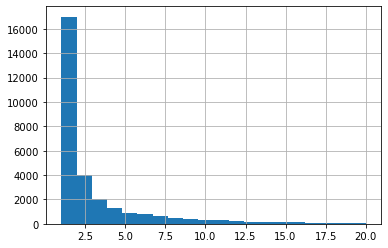

In [116]:
entry_counts_perpatient = filtered_df["PatientID"].value_counts()

entry_counts_perpatient[entry_counts_perpatient <=20].hist(bins=20)

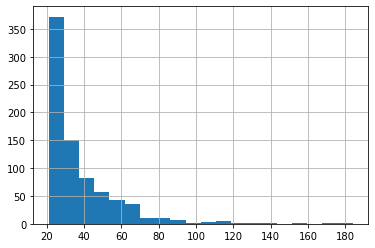

In [117]:
entry_counts_perpatient[entry_counts_perpatient > 20].hist(bins=20)

In [118]:
(entry_counts_perpatient[entry_counts_perpatient >= 50]).sum() / entry_counts_perpatient.sum()

0.09900383842076403

#### Findings

1. The distribution of the entry count per patient have long tail. 50% of patient have more than 10 entries and 10% of patients have more than 50 entries.

## 8. Pixel-level assassements

In [129]:
def plot_pixel_hist(img, ax):    
    ax.hist((img.ravel() * 255).astype(np.int), bins=255);
    
def plot_disease_images(df, label, title):
    fig, axes = plt.subplots(2, 4, figsize=(17, 8))
    ax_list = axes.flatten()
    fig.suptitle(title, fontsize=16)
    
    target_df = df[df[label] ==1]
    n_max = target_df.shape[0]
    n_sample = 8 if n_max >= 8 else n_max
    
    i = 0
    for idx, row in df[df[label] ==1].sample(n_sample, random_state=0).iterrows():
        ax = ax_list[i]
        img = plt.imread(row["ImagePath"])
        ax.set_title(row["ImageIndex"])
        ax.imshow(img, cmap='gray')
        i += 1
    
def plot_disease_pixel_hist(df, label, title):
    fig, axes = plt.subplots(2, 4, figsize=(17, 8))
    ax_list = axes.flatten()
    fig.suptitle(title, fontsize=16)
    
    target_df = df[df[label] ==1]
    n_max = target_df.shape[0]
    n_sample = 8 if n_max >= 8 else n_max
    
    i = 0
    for idx, row in df[df[label] ==1].sample(n_sample, random_state=0).iterrows():
        ax = ax_list[i]
        img = plt.imread(row["ImagePath"])
        ax.hist((img.ravel() * 255).astype(np.int), bins=255);
        ax.set_ylim(0, 15000)
        i += 1


In [120]:
single_label_df = sample_df[sample_df[all_labels].sum(axis=1) == 1]

for label in all_labels:
    print(label, (single_label_df[label] == 1).sum())
    

Atelectasis 192
Cardiomegaly 50
Consolidation 72
Edema 41
Effusion 203
Emphysema 42
Fibrosis 38
Hernia 5
Infiltration 502
Mass 99
No Finding 3043
Nodule 144
Pleural_Thickening 65
Pneumonia 14
Pneumothorax 114


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


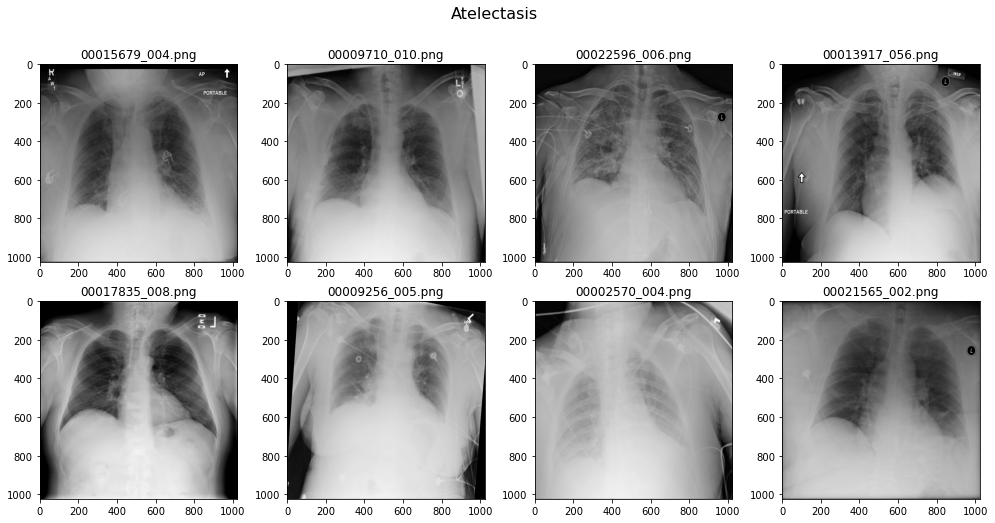

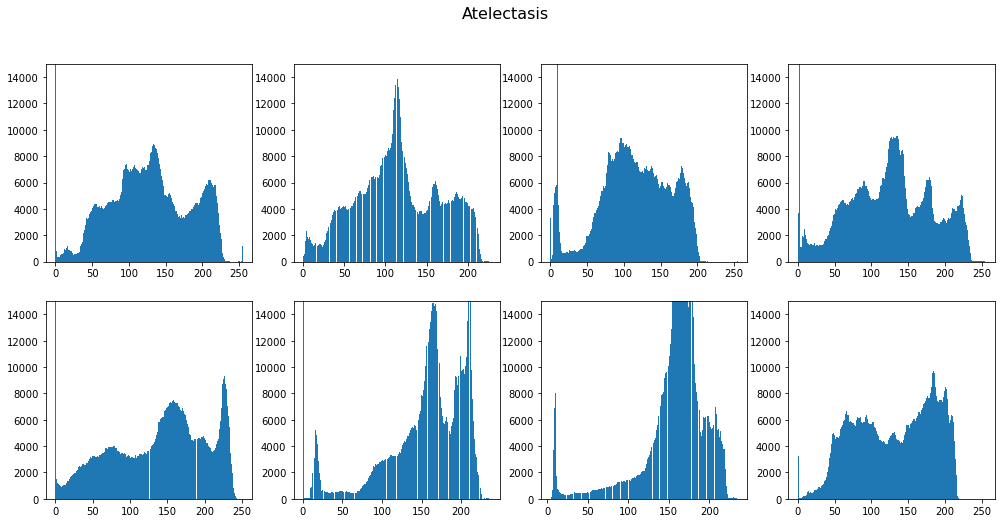

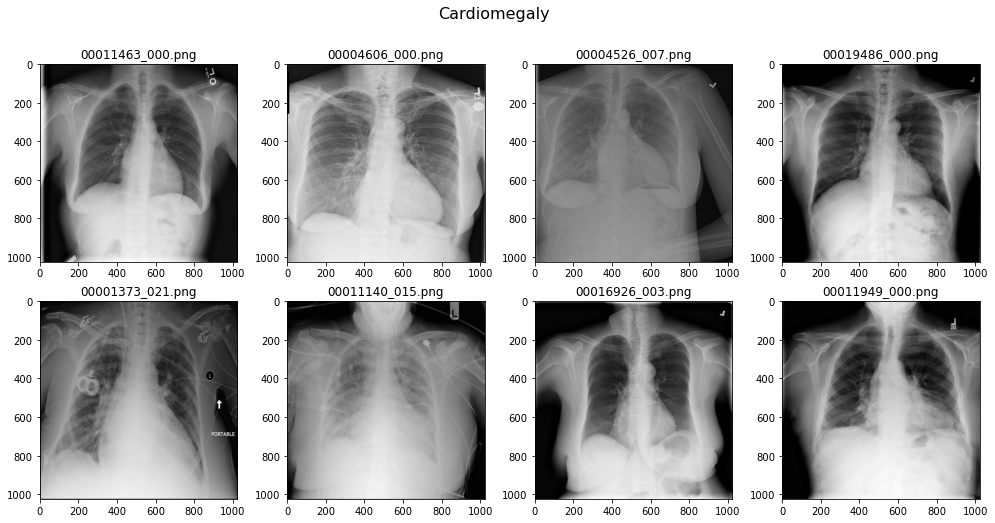

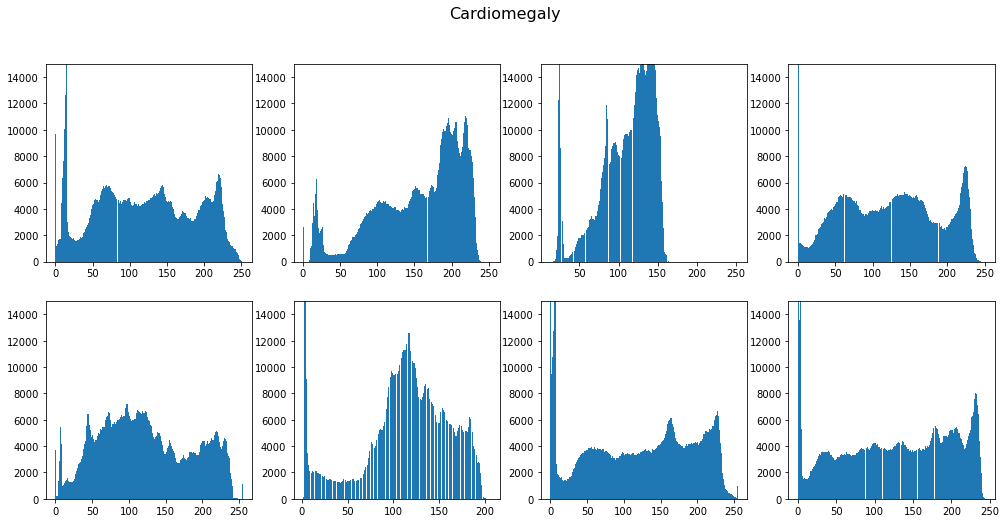

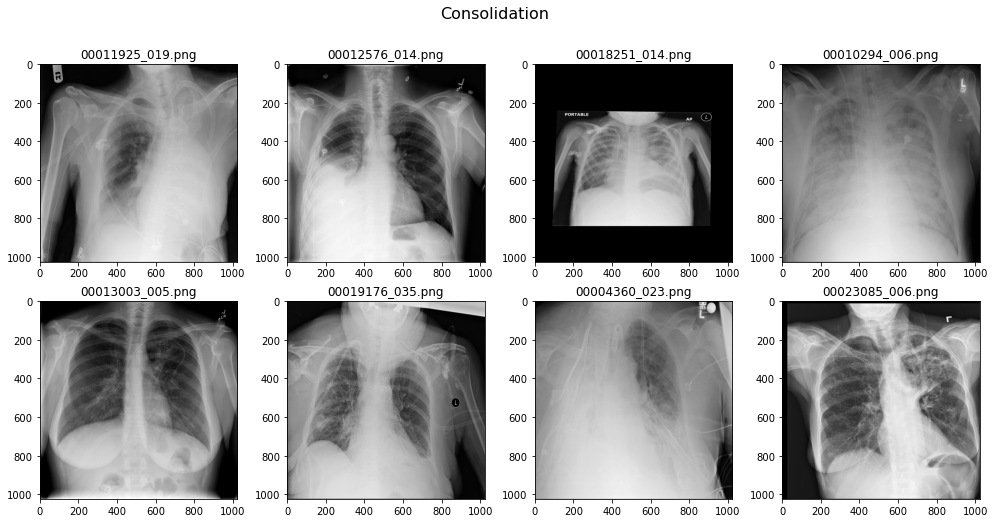

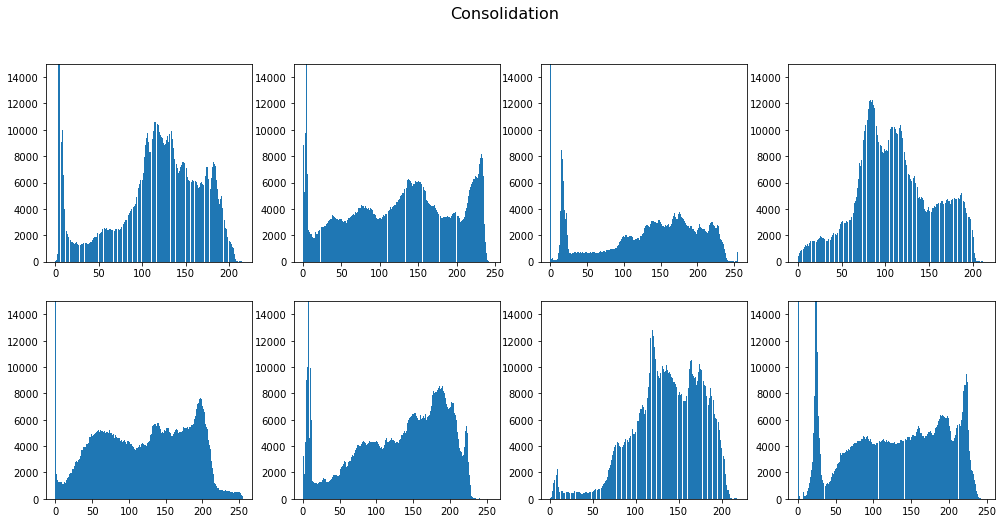

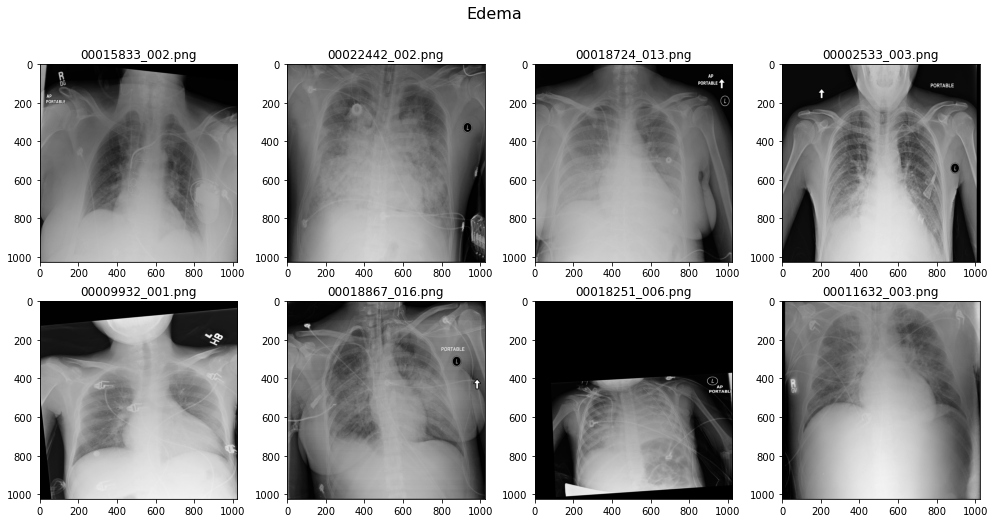

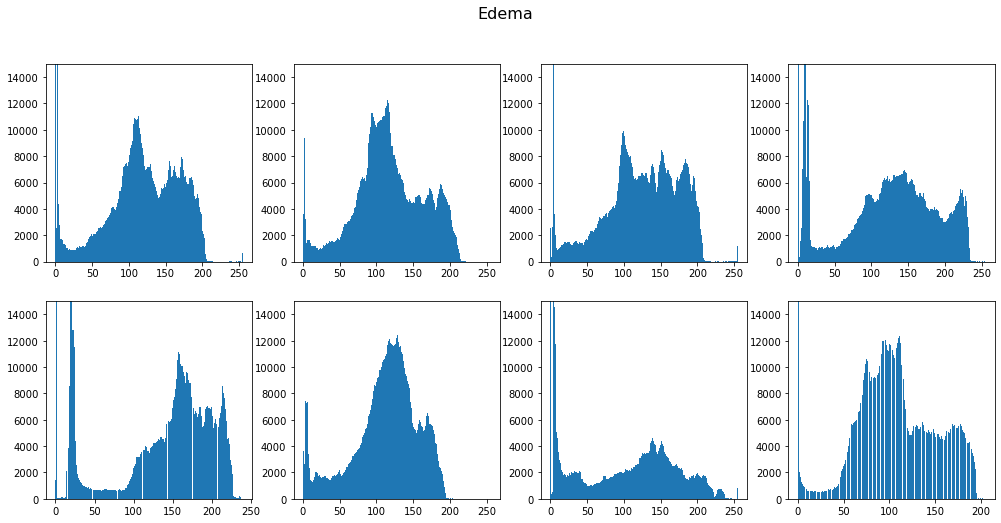

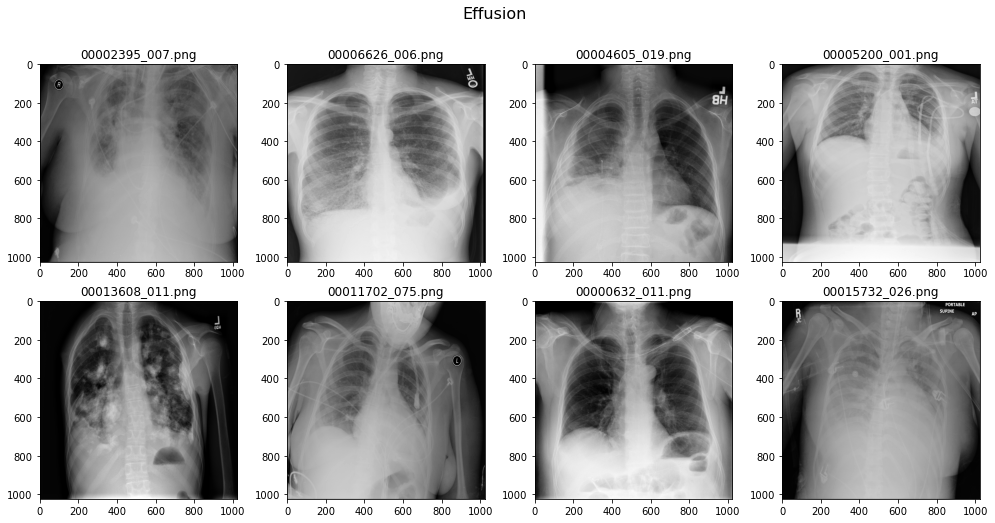

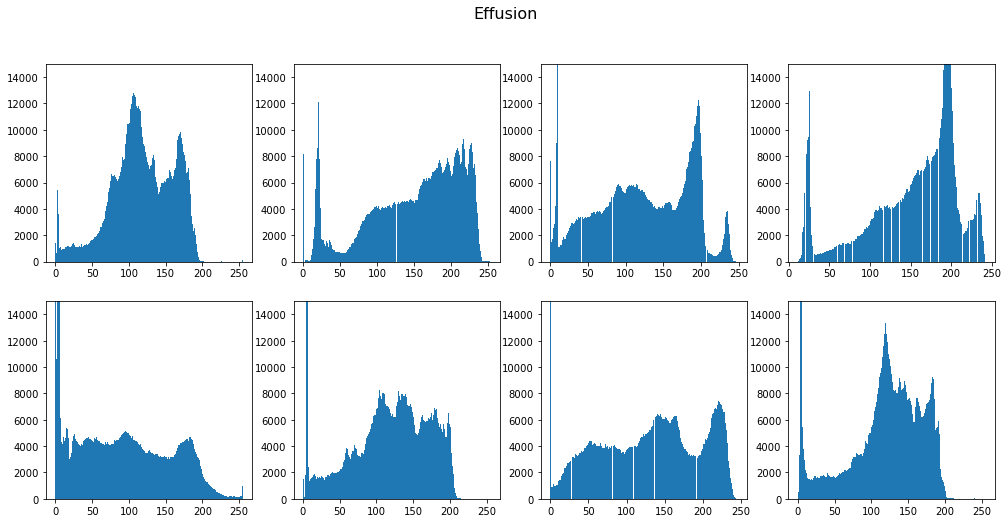

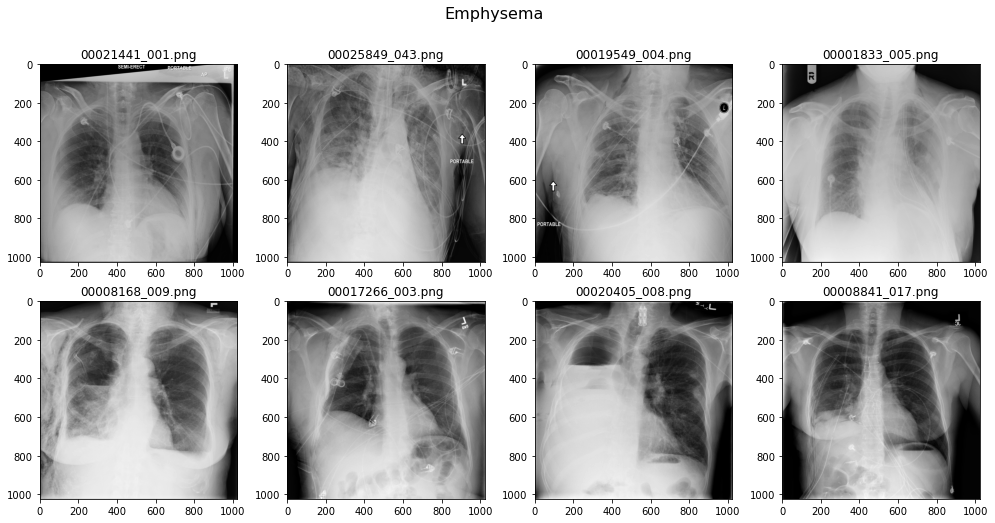

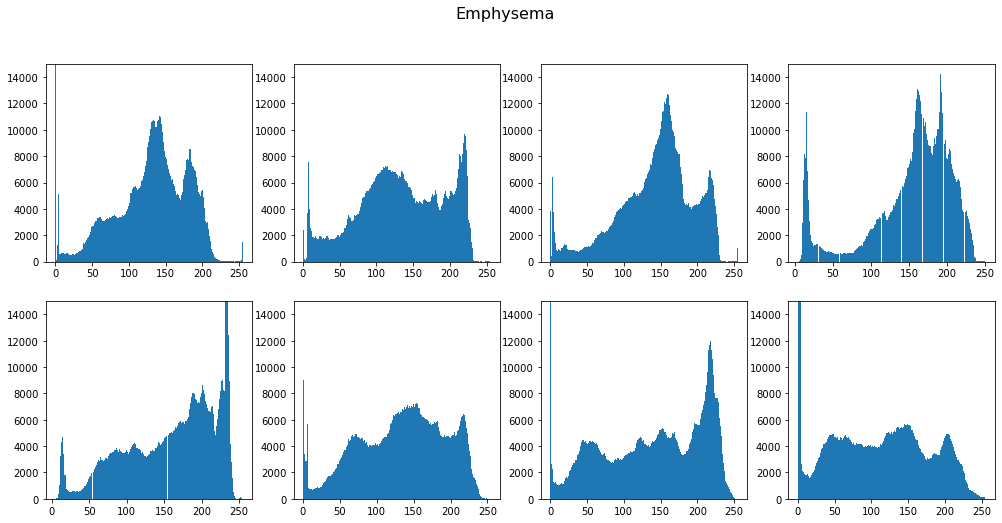

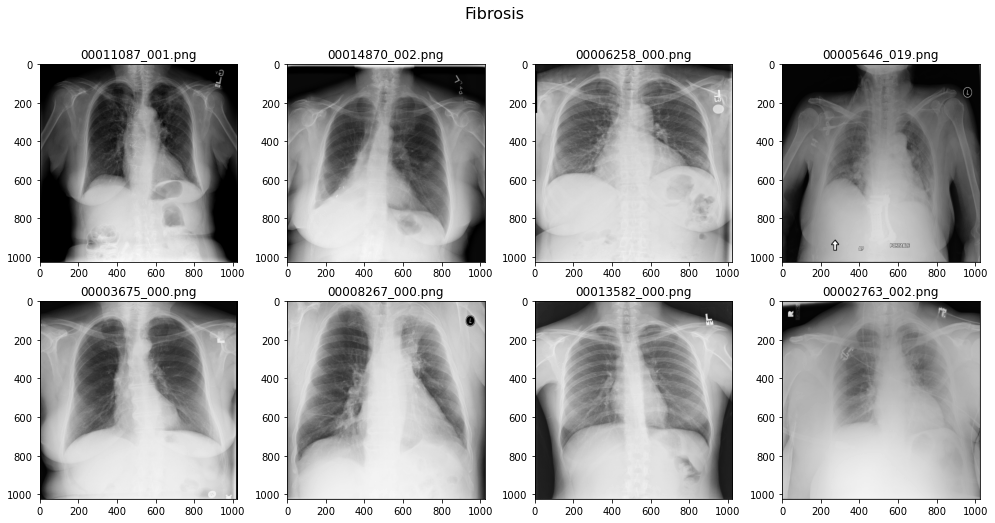

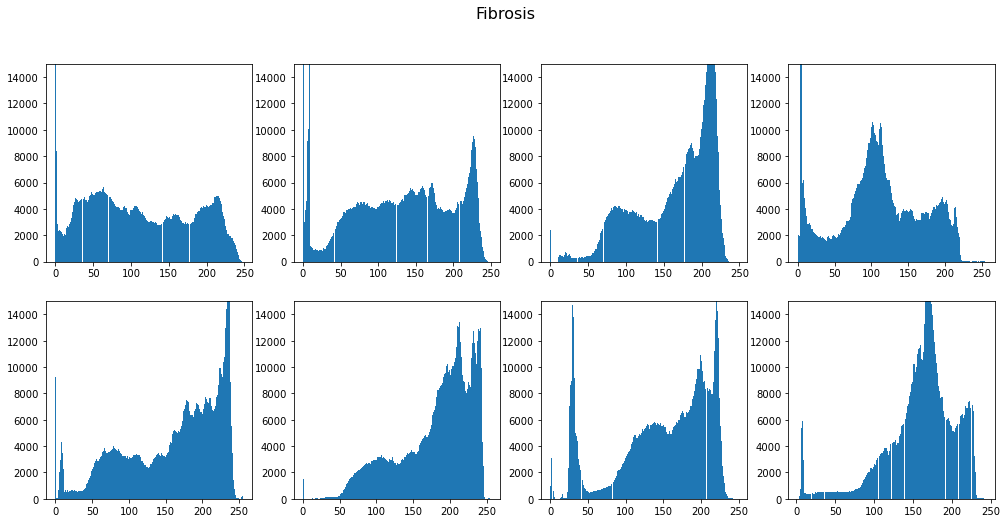

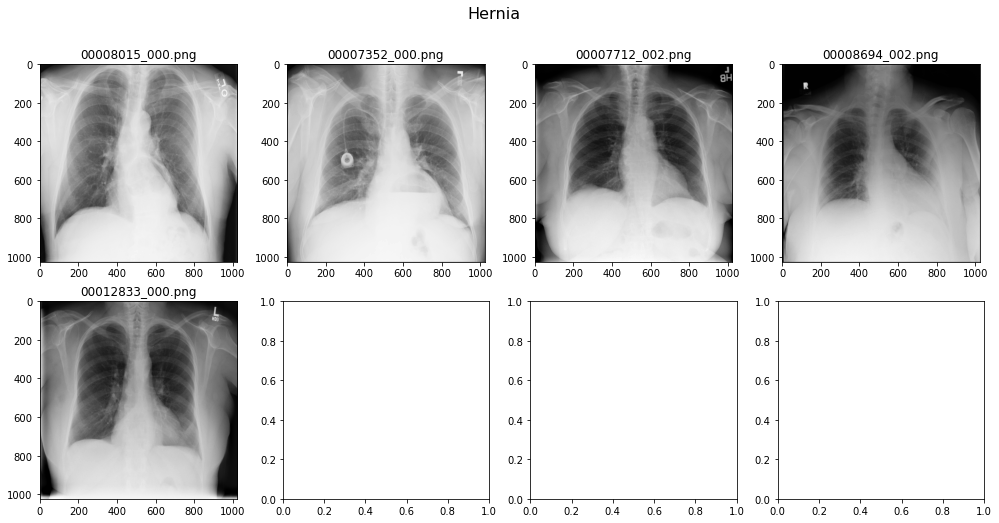

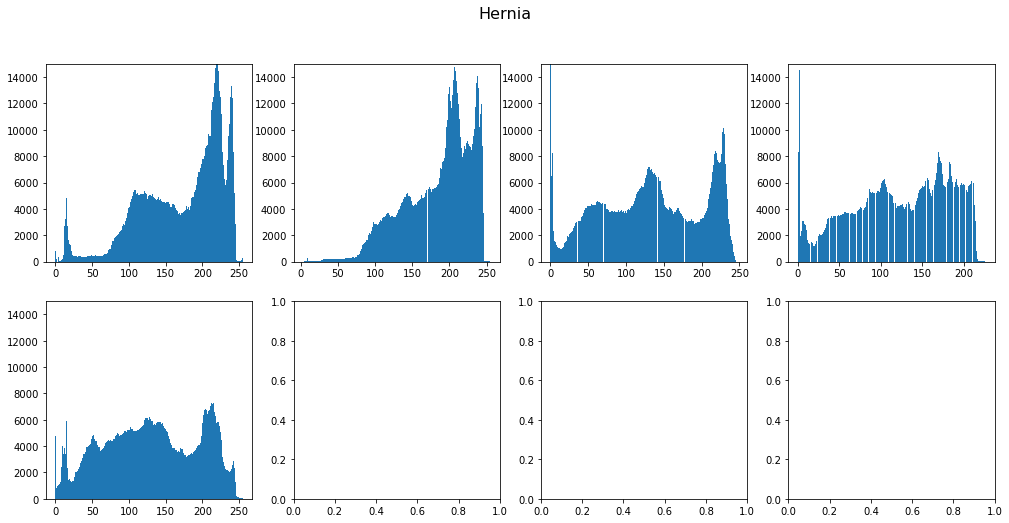

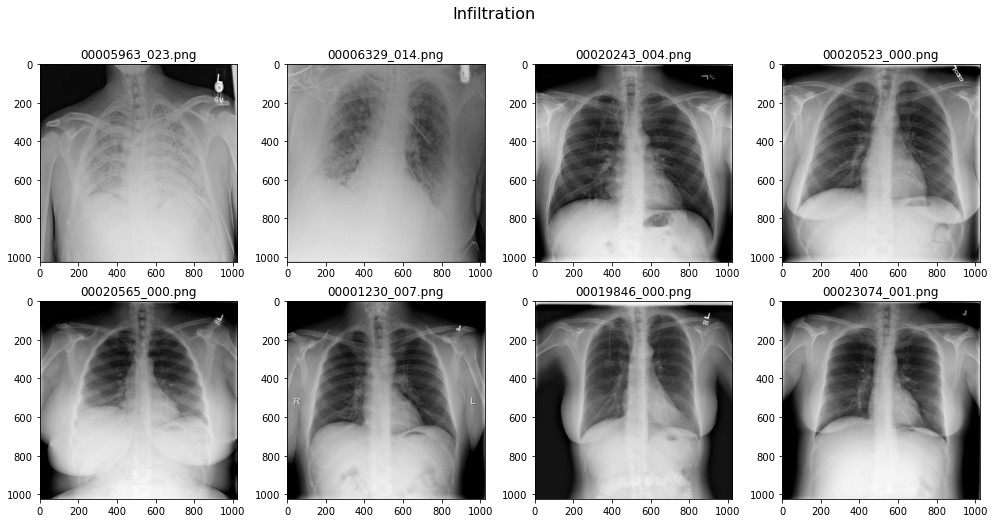

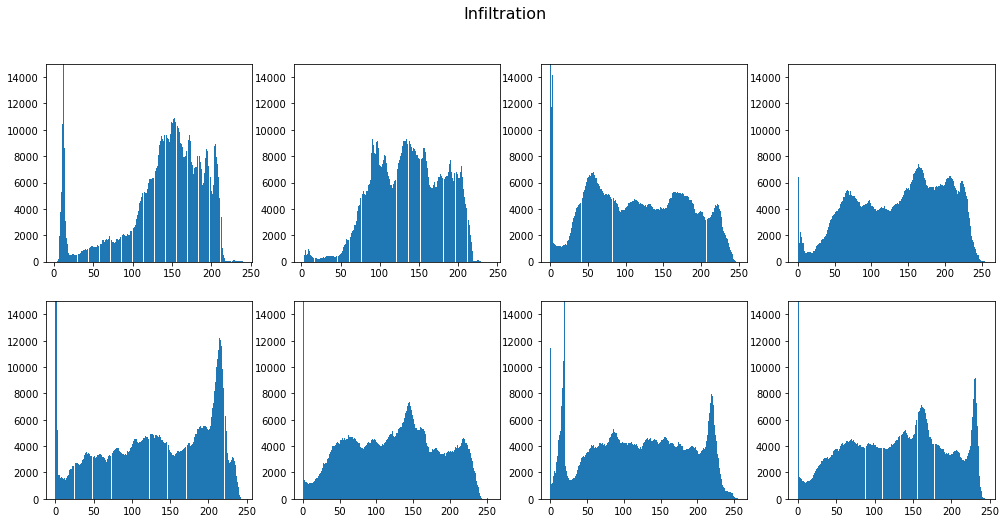

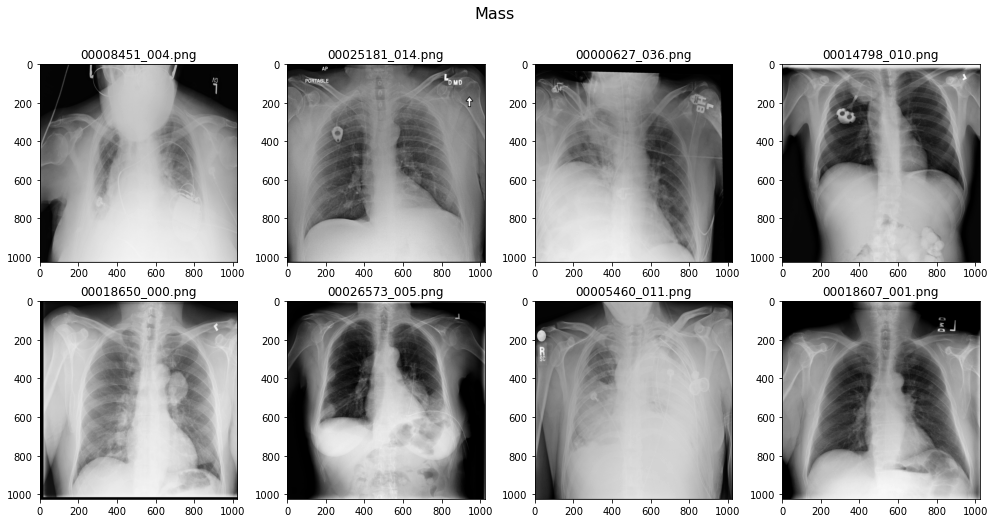

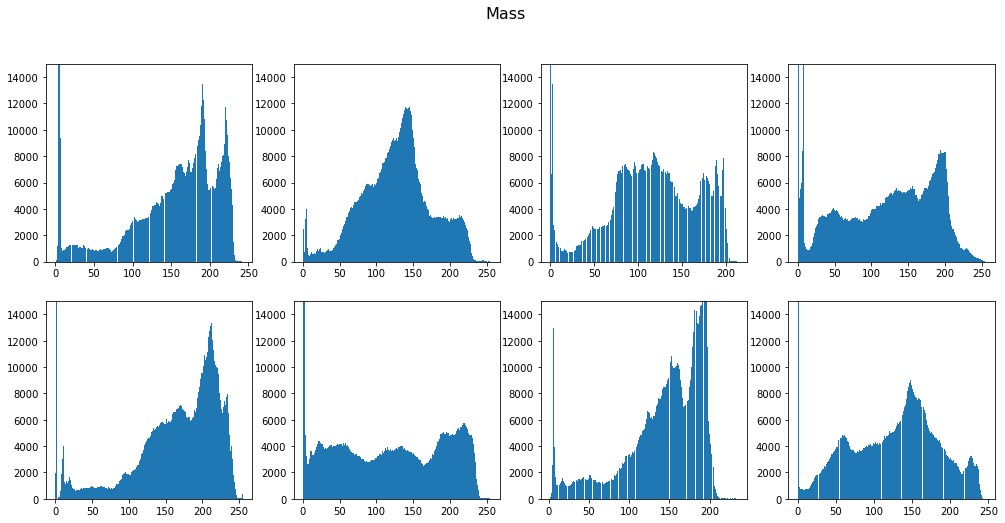

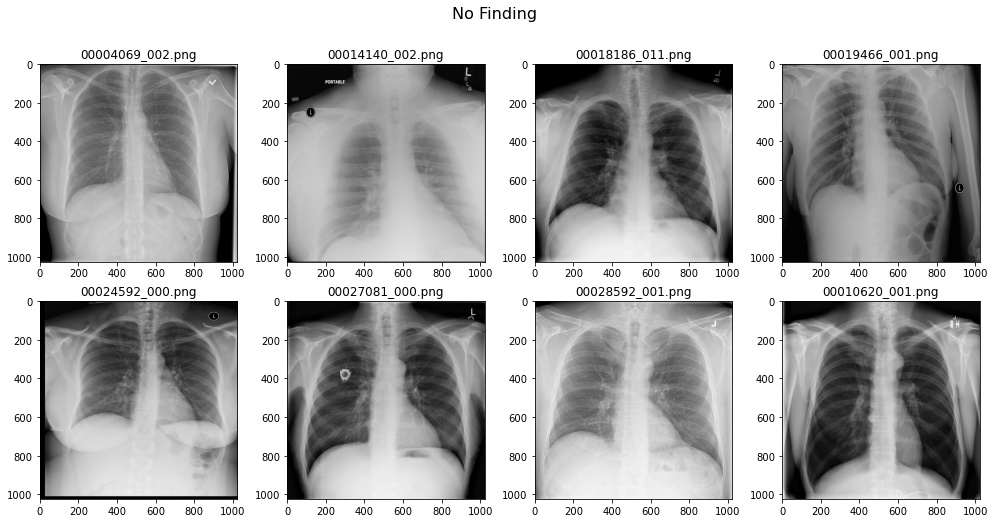

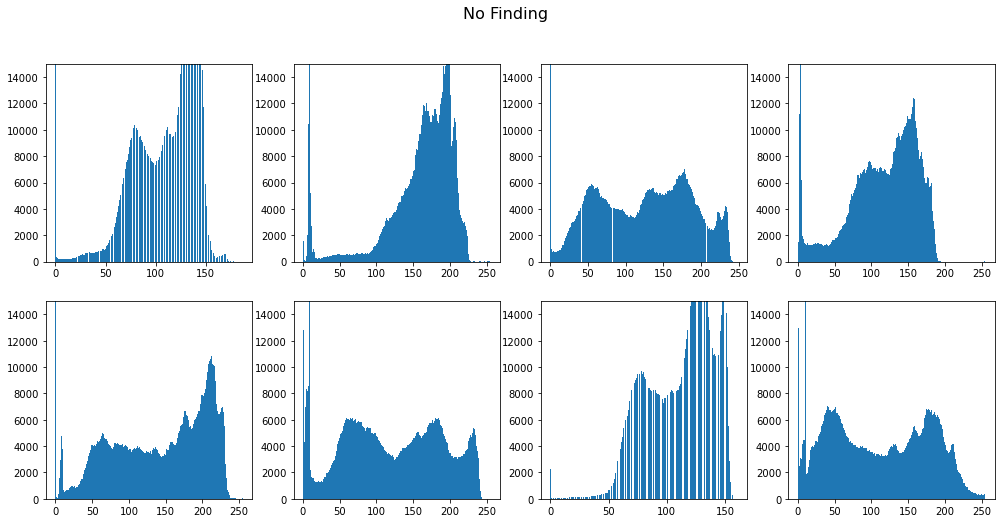

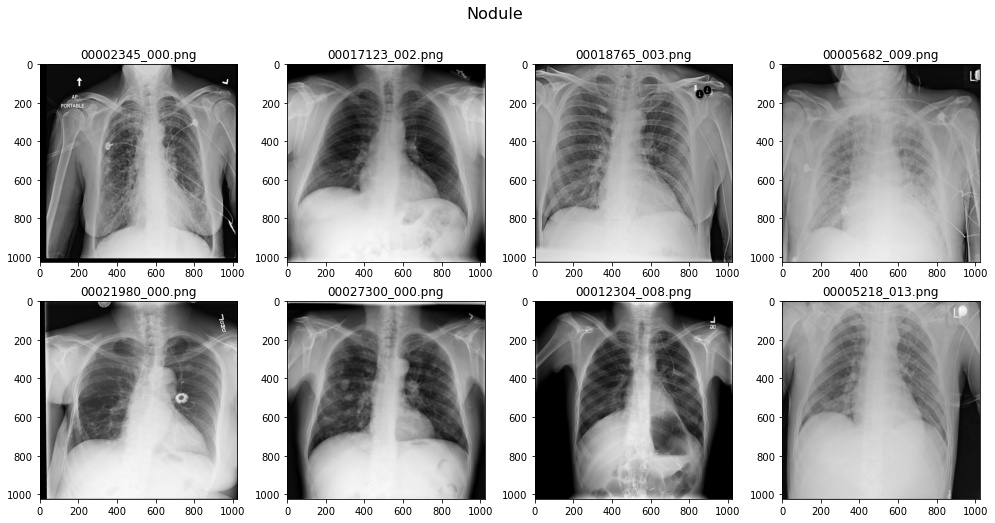

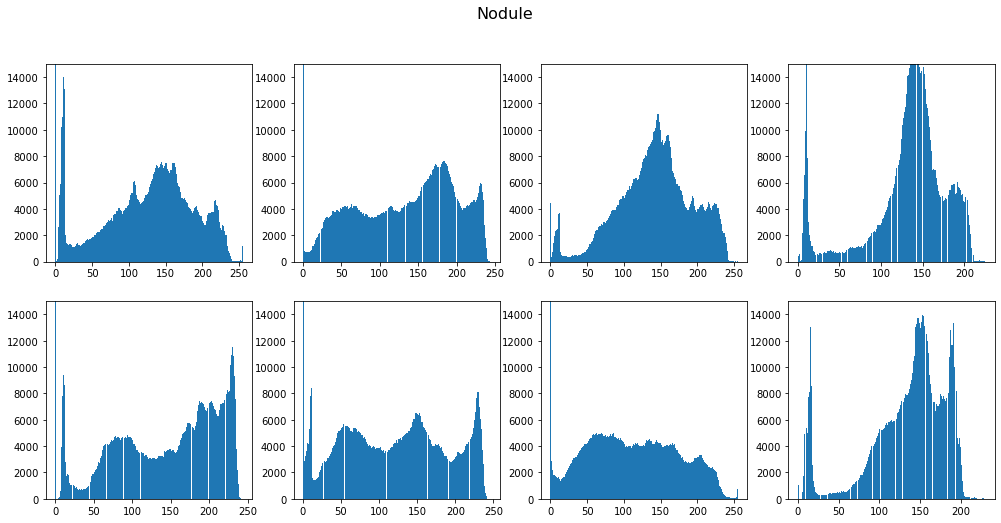

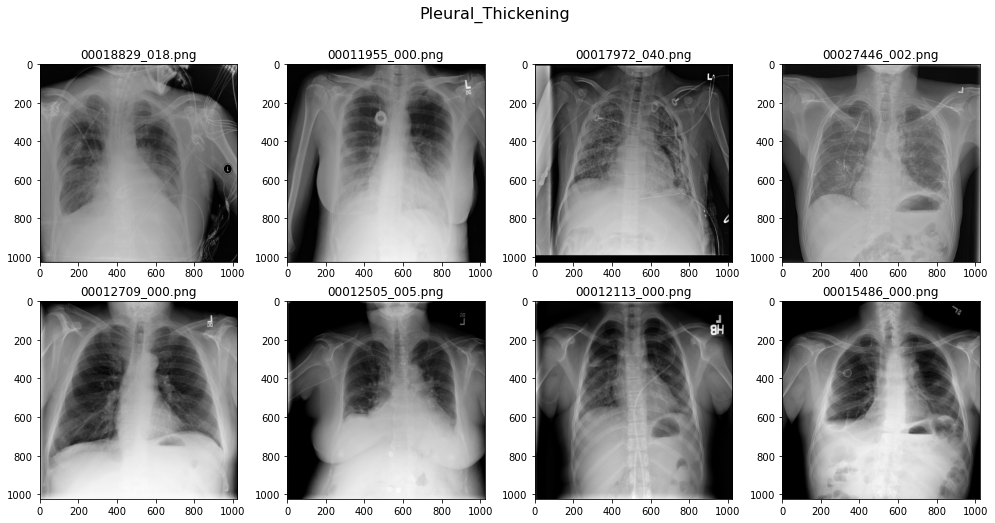

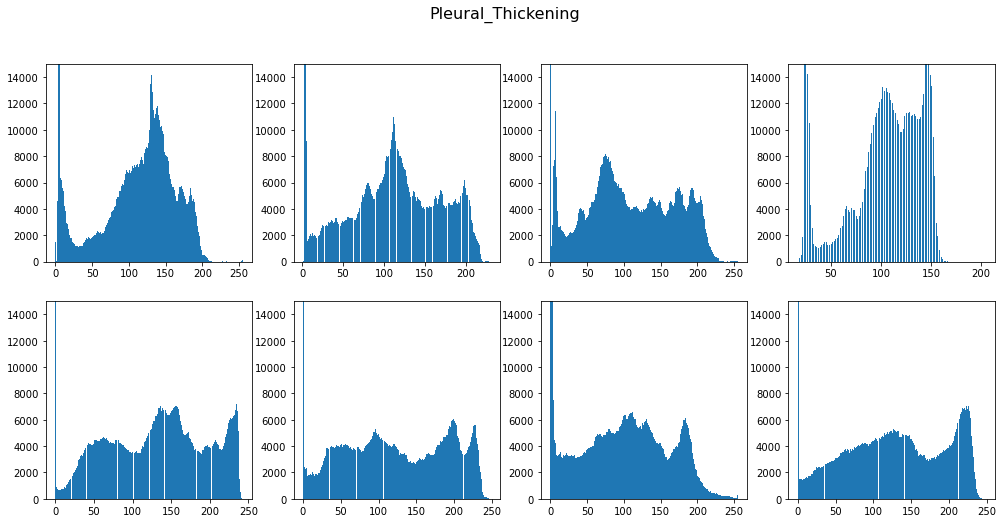

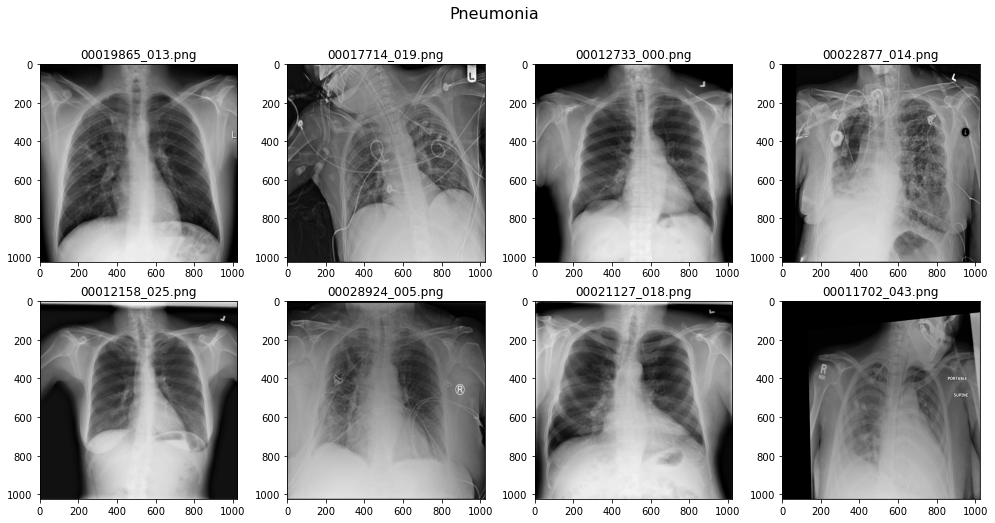

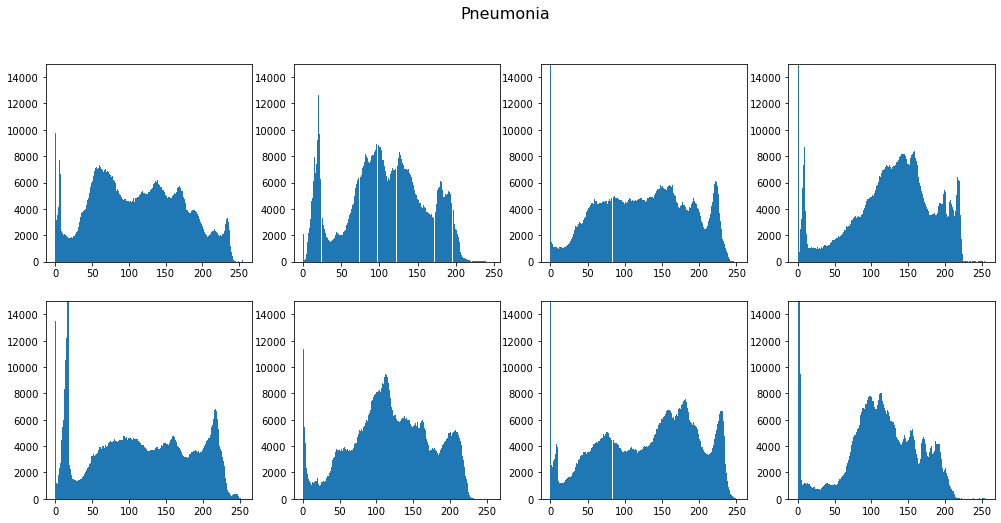

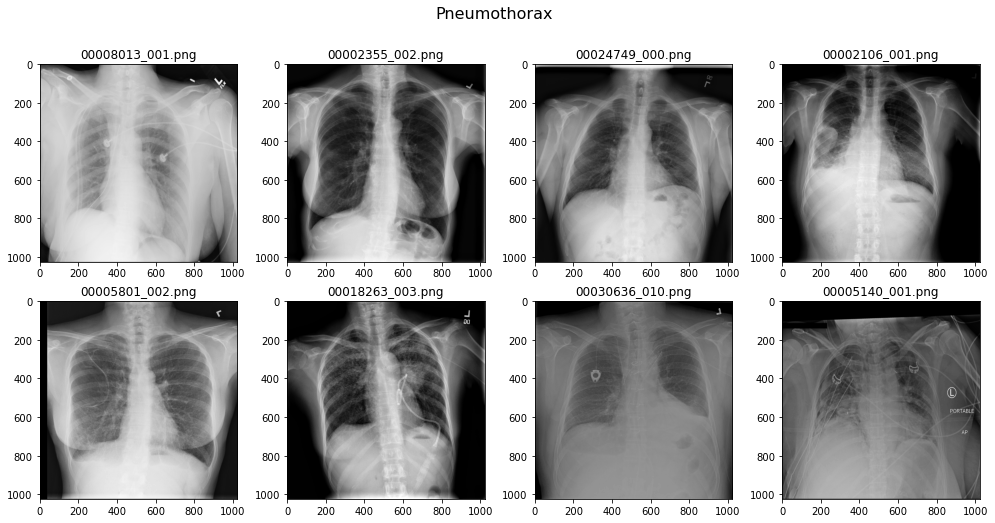

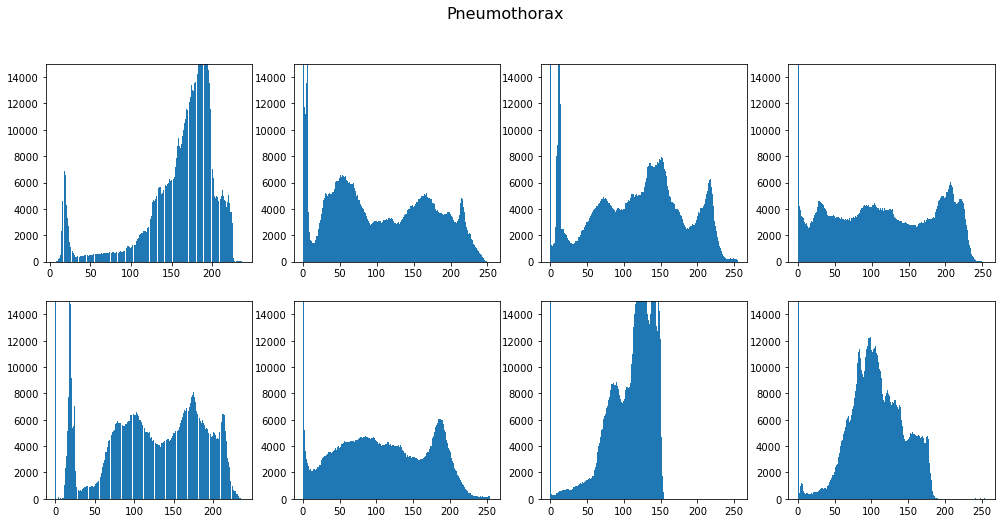

In [130]:
for label in all_labels:    
    plot_disease_images(single_label_df, label, label)
    plot_disease_pixel_hist(single_label_df, label, label)

**Note. 
Here, I showed images which have a single label.**

### Image with bounding box

In order to grasp how to interpret images. I showed some images including bounding box.

In [122]:
## Read bounding boxes
bbox_df = pd.read_csv('/data/BBox_List_2017.csv')
bbox_df = bbox_df.iloc[:, [0, 1, 2, 3, 4, 5]]
bbox_df.columns = ["ImageIndex", "FindingLabel", "bb_x", "bb_y",  "bb_w", "bb_h"]

In [123]:
bbox_df.head()

ImageIndex FindingLabel        bb_x        bb_y        bb_w  \
0  00013118_008.png  Atelectasis  225.084746  547.019217   86.779661   
1  00014716_007.png  Atelectasis  686.101695  131.543498  185.491525   
2  00029817_009.png  Atelectasis  221.830508  317.053115  155.118644   
3  00014687_001.png  Atelectasis  726.237288  494.951420  141.016949   
4  00017877_001.png  Atelectasis  660.067797  569.780787  200.677966   

         bb_h  
0   79.186441  
1  313.491525  
2  216.949153  
3   55.322034  
4   78.101695

In [124]:
bbox_df["FindingLabel"].value_counts()

Atelectasis     180
Effusion        153
Cardiomegaly    146
Infiltrate      123
Pneumonia       120
Pneumothorax     98
Mass             85
Nodule           79
Name: FindingLabel, dtype: int64

In [125]:
bbox_labels = bbox_df["FindingLabel"].value_counts().index.values
bbox_df = all_xray_df.merge(bbox_df,  on="ImageIndex")

In [126]:
bbox_df

ImageIndex                              Labels  FollowUp  \
0    00000032_037.png     Cardiomegaly|Edema|Infiltration        37   
1    00000072_000.png                         Atelectasis         0   
2    00000147_001.png                         Atelectasis         1   
3    00000149_006.png                         Atelectasis         6   
4    00000150_002.png  Atelectasis|Infiltration|Pneumonia         2   
..                ...                                 ...       ...   
979  00030634_000.png                            Effusion         0   
980  00030635_001.png                Atelectasis|Effusion         1   
981  00030636_004.png            Atelectasis|Infiltration         4   
982  00030636_004.png            Atelectasis|Infiltration         4   
983  00030674_000.png                         Atelectasis         0   

     PatientID  PatientAge PatientGender ViewPosition  OriginalImageWidth  \
0           32          55             F           AP                2500   
1           72          67             F           PA                2450   
2          147          66             F           PA                2742   
3          149          71             M           AP                2500   
4          150          55             F           AP                3056   
..         ...         ...           ...          ...                 ...   
979      30634          60             F           PA                2544   
980      30635          51             F           PA                1798   
981      30636          45             M           AP                3056   
982      30636          45             M           AP                3056   
983      30674          80             M           PA                2021   

     OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                   2048                     0.168000   
1                   2839                     0.143000   
2                   2948                     0.143000   
3                   2048                     0.168000   
4                   2544                     0.139000   
..                   ...                          ...   
979                 3056                     0.139000   
980                 1815                     0.194314   
981                 2544                     0.139000   
982                 2544                     0.139000   
983                 2020                     0.194311   

     OriginalImagePixelSpacing_y                                 ImagePath  \
0                       0.168000  /data/images_001/images/00000032_037.png   
1                       0.143000  /data/images_001/images/00000072_000.png   
2                       0.143000  /data/images_001/images/00000147_001.png   
3                       0.168000  /data/images_001/images/00000149_006.png   
4                       0.139000  /data/images_001/images/00000150_002.png   
..                           ...                                       ...   
979                     0.139000  /data/images_012/images/00030634_000.png   
980                     0.194314  /data/images_012/images/00030635_001.png   
981                     0.139000  /data/images_012/images/00030636_004.png   
982                     0.139000  /data/images_012/images/00030636_004.png   
983                     0.194311  /data/images_012/images/00030674_000.png   

    FindingLabel        bb_x        bb_y        bb_w        bb_h  
0     Infiltrate  339.166138  119.195767  172.292063  351.085714  
1    Atelectasis  356.503704  567.805291  127.864550   82.353439  
2    Atelectasis  617.650794  599.229630  100.774603  179.877249  
3    Atelectasis  603.661017  460.239556  249.491525   90.033898  
4      Pneumonia  601.396825  595.978836  215.635979  180.960847  
..           ...         ...         ...         ...         ...  
979     Effusion  141.653333  611.309045  317.440000   96.711111  
980  Atelectasis  576.542373  490.612437  240.813559  222.372881  
981   In

In [127]:
def get_bbox(row):
    x = row["bb_x"]
    y = row["bb_y"]
    w = row["bb_w"]
    h = row["bb_h"]
    return Rectangle((x, y), w, h, color ='red', fill=False) 
    
def plot_bbox(df, label, title):
    fig, axes = plt.subplots(2, 4, figsize=(17, 8))
    ax_list = axes.flatten()
    fig.suptitle(title, fontsize=16)
    
    target_df = df[df["FindingLabel"] == label]
    n_max = target_df.shape[0]
    n_sample = 8 if n_max >= 8 else n_max
    
    i = 0
    for idx, row in df[df["FindingLabel"] ==label].sample(n_sample, random_state=0).iterrows():
        ax = ax_list[i]
        img = plt.imread(row["ImagePath"])

        rect = get_bbox(row)        
        ax.add_patch(rect)
        ax.imshow(img, cmap='gray')
        i += 1
    
    

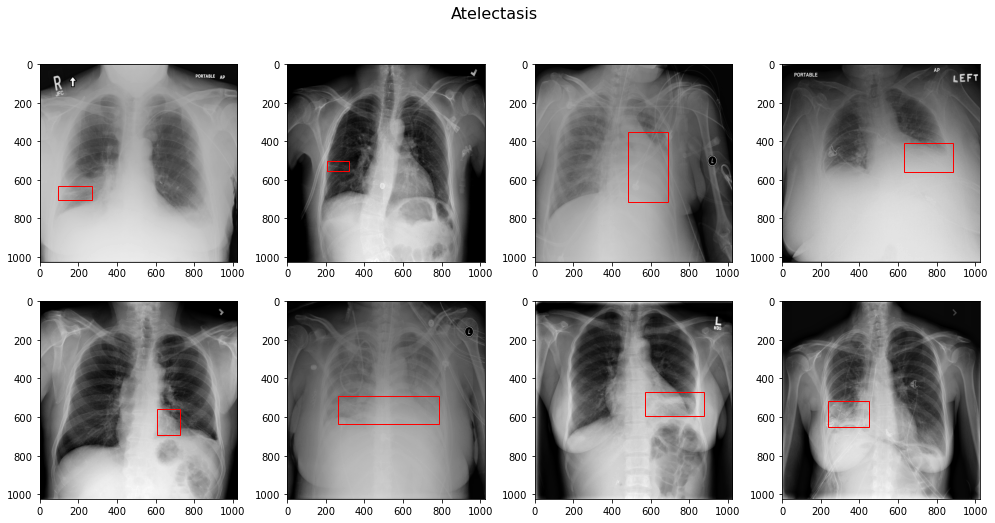

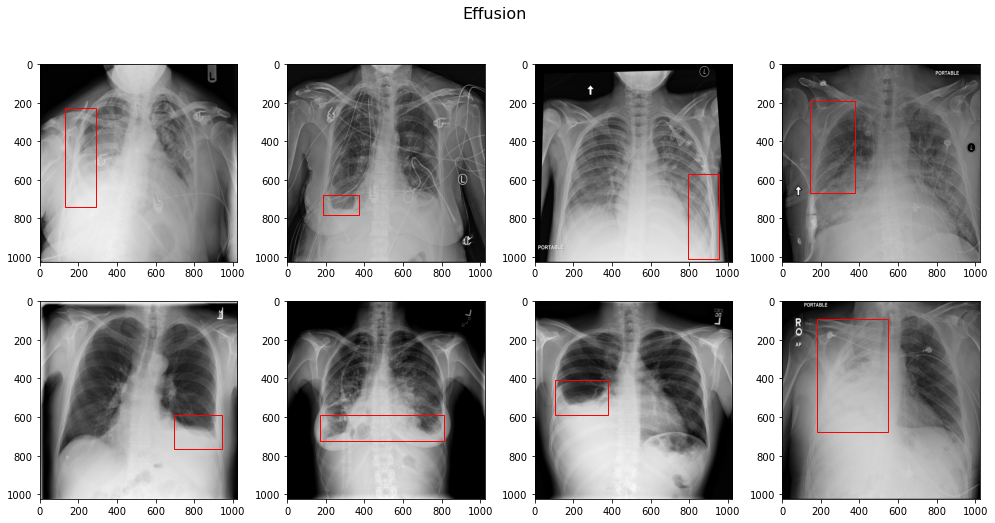

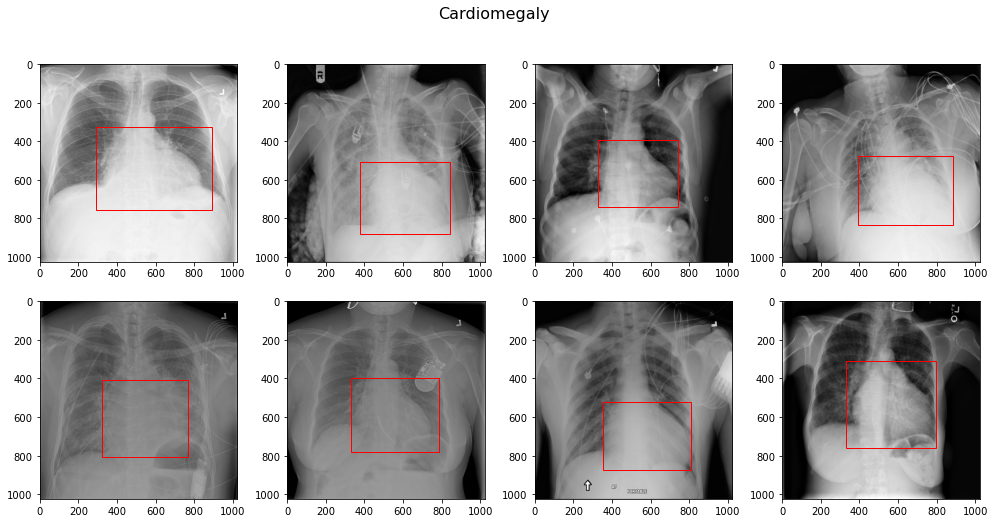

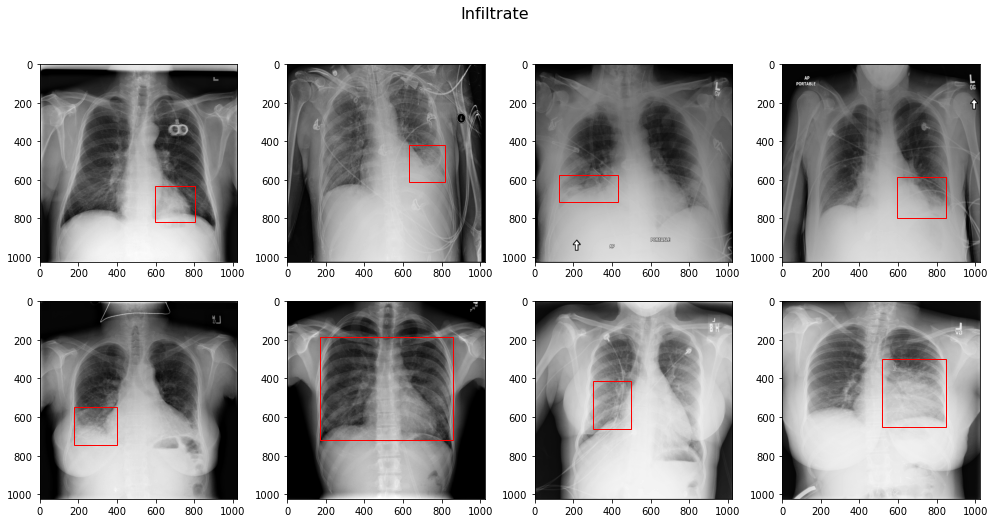

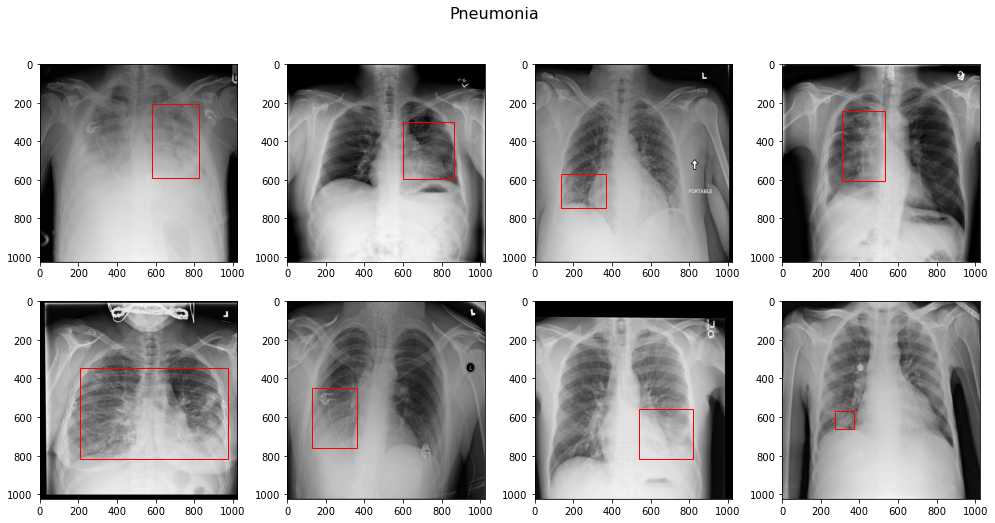

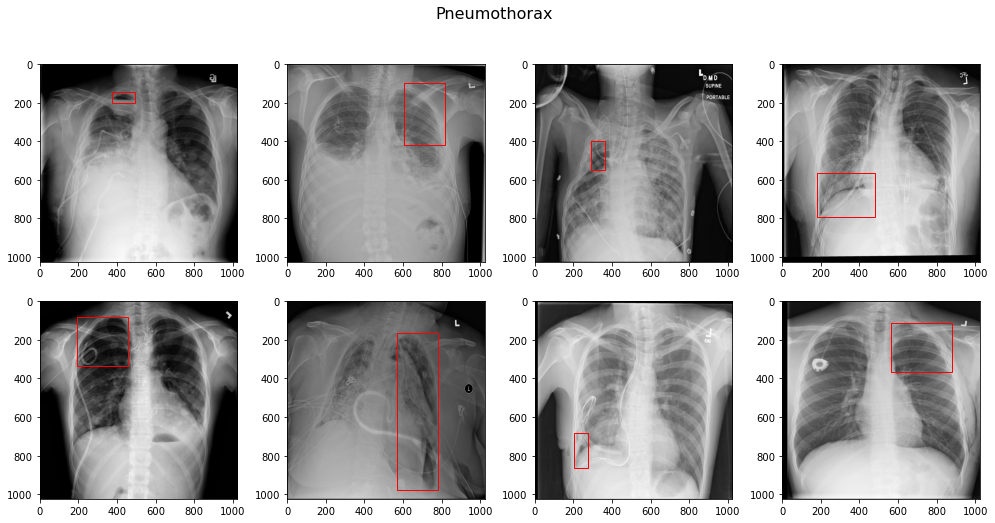

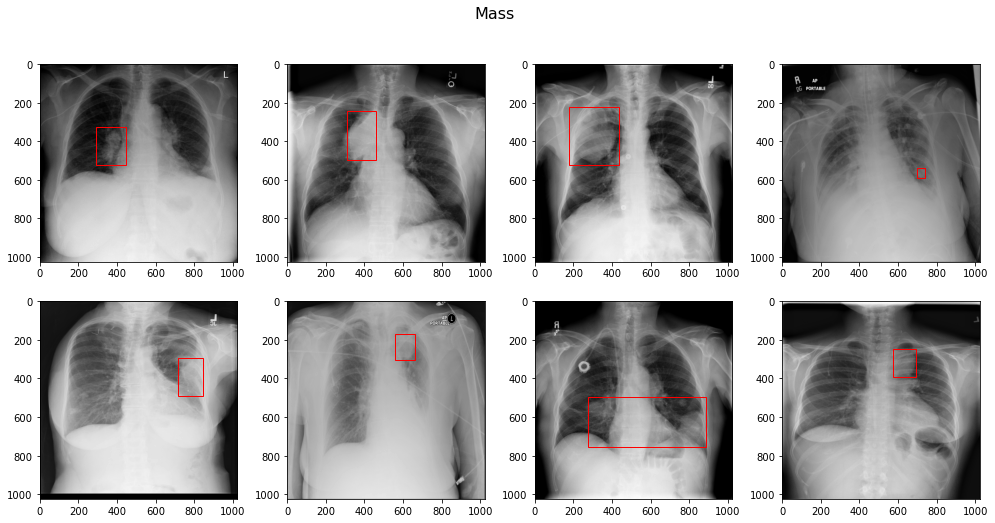

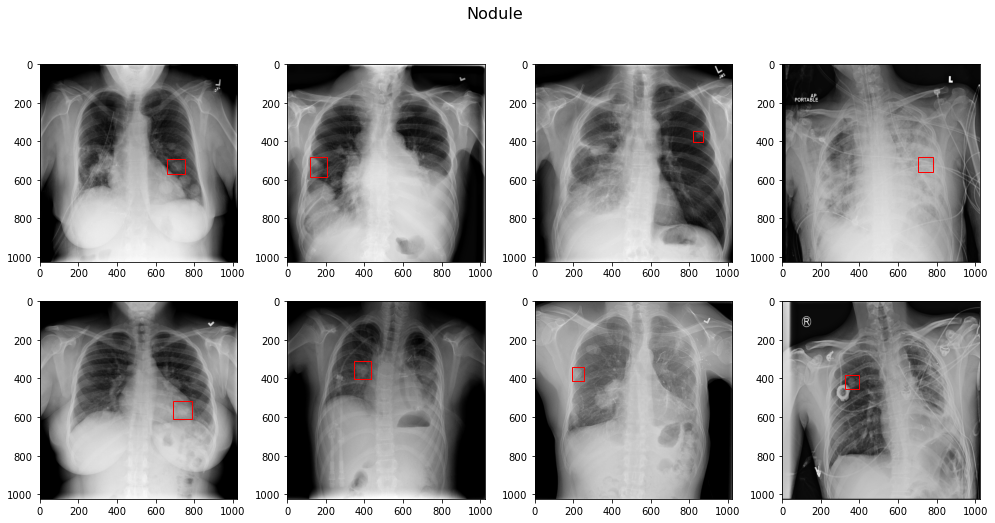

In [128]:
for label in bbox_labels:
    plot_bbox(bbox_df, label, label)


### Findings
1. Honestly, I couldn't discern any disease from the histgram.
2. Some diseases appears in a specific location like "Cardiomegaly". But "Pneumonia" or other disease can appear in any location of lung.
3. The area where the "Pneumonia" appears vary from small reagion to whole lung area. On the other hand, "Nodule" will appears in relatively small region.
4. The 42% of "Pneumonia" casea have "Infiltrate" simultaniously. This is becase the "Pneumonia" sometimes causes "Infiltrate". This co-occurance can work to make our model learn the "Infiltrate" as Positive cases.
5. In the image with disease, sometimes there are some artifacts like appliance atached to the patients. The model should be tolerant to such  artifacts. For example, in the training phase, we can introduce a data augmentation in which we artificially overwrite appliance's silhouette on the original image.
6. Since some images have multiple label which makes difficult to discern labels.